<a href="https://colab.research.google.com/github/sharonwu827/Deep-Learning/blob/master/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings


## Word Embedding Layers for Deep Learning with Keras

Keras offers an Embedding layer that can be used for neural networks on text data.

- It requires that the input data be integer encoded, so that **each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.**

### The Embedding layer 

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for the problem.
- input_length: This is the length of input sequences. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [15]:
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

Example: a small problem where we have 10 text documents, each with a comment about a piece of work a student submitted. Each text document is classified as positive “1” or negative “0”. 





In [6]:

docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])

Keras provides the one_hot() function that creates a hash of each word as an efficient integer encoding. We will estimate the vocabulary size of 50, which is much larger than needed to reduce the probability of collisions from the hash function.


In [17]:
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[45, 47], [28, 9], [24, 32], [39, 9], [1], [28], [44, 32], [35, 28], [44, 9], [12, 16, 47, 1]]


The sequences have different lengths and **Keras prefers inputs to be vectorized and all inputs to have the same length**. We will pad all input sequences to have the length of 4. we can do this with a built in Keras function.pad_sequences()

In [18]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[45 47  0  0]
 [28  9  0  0]
 [24 32  0  0]
 [39  9  0  0]
 [ 1  0  0  0]
 [28  0  0  0]
 [44 32  0  0]
 [35 28  0  0]
 [44  9  0  0]
 [12 16 47  1]]


The Embedding has a vocabulary of 50 and an input length of 4. We will choose a small embedding space of 8 dimensions.

The model is a simple binary classification model. Importantly, the output from the Embedding layer will be **4 vectors of 8 dimensions** each, one for each word. We flatten this to a one 32-element vector to pass on to the Dense output layer.

In [20]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size
                    , 8
                    , input_length=max_length 
                    ))
model.add(Flatten()) # We flatten this to a one 32-element vector to pass on to the Dense output layer.
model.add(Dense(1, activation='sigmoid'))

In [21]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 80.000001


After the network is defined, above shows a summary of the layers. The output of the Embedding layer is a 4×8 matrix and this is squashed to a 32-element vector by the Flatten layer.

##  Bert

BERT is a model that knows to represent text. You give it some sequence as an input, it then looks left and right several times and produces a vector representation for each word as the output.

BERT relies on a Transformer. A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. **The input to the encoder for BERT is a sequence of tokens**, which are first converted into vectors and then processed in the neural network. But before processing can start, **BERT needs the input to be massaged and decorated with some extra metadata:**

- **Token embeddings**: A [CLS] token is added to the input **word tokens** at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
- **Segment embeddings**: A marker indicating **Sentence A or Sentence B is added to each token**. This allows the encoder to distinguish between sentences.
- **Positional embeddings**: A positional embedding is added to each token to indicate its position in the sentence.

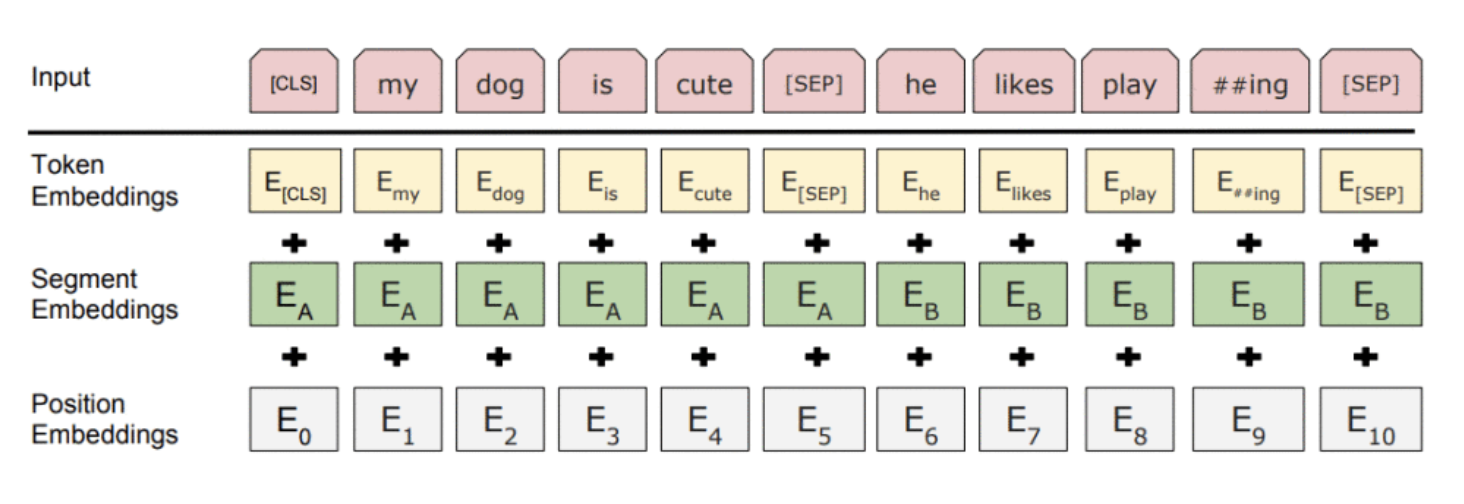



Because BERT is a pretrained model that expects input data in a specific format, we will need:

- A special token, [CLS], at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is.
- A special token, [SEP], to mark the end of a sentence, or the separation between two sentences
Tokens that conform with the fixed vocabulary used in BERT
- The Token IDs for the tokens, from BERT’s tokenizer
Mask IDs to indicate which elements in the sequence are tokens and which are padding elements
- Segment IDs used to distinguish different sentences
- Positional Embeddings used to show token position within the sequence


In [27]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

INFO:filelock:Lock 139740738297232 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 139740738297232 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 139740725629840 acquired on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


INFO:filelock:Lock 139740725629840 released on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


INFO:filelock:Lock 139740725586576 acquired on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


INFO:filelock:Lock 139740725586576 released on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


In [28]:
text = "Here is the sentence I want embeddings for: "
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


"embeddings" has been split into smaller subwords and characters. The two hash signs (##) preceding some of these subwords are just our tokenizer’s way to denote that this subword or character is part of a larger word and preceded by another subword. So, for example, the ‘##bed’ token is separate from the ‘bed’ token; the first is used whenever the subword ‘bed’ occurs within a larger word and the second is used explicitly for when the standalone token ‘thing you sleep on’ occurs.

After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.


In [29]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.



In [31]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Running BERT on our text

Next we need to convert our data to torch tensors and call the BERT model. **The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists**, so we convert the lists here - this does not change the shape or the data.

In [32]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [33]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

INFO:filelock:Lock 139740712542288 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


INFO:filelock:Lock 139740712542288 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


INFO:filelock:Lock 139740707910864 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


INFO:filelock:Lock 139740707910864 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [35]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2] # The full set of hidden states for this model, stored in the object hidden_statesprint ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")

layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


### hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors…but which layer or combination of layers provides the best representation?

Unfortunately, there’s no single easy answer… Let’s try a couple reasonable approaches, though. Afterwards, I’ll point you to some helpful resources which look into this question further.


#### Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [36]:
# `hidden_states` has shape [13 x 1 x 22 x 768]
# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)